<a href="https://colab.research.google.com/github/joelma78/colab-github-actions/blob/main/ML2_Cacau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.PROJETO DE MACHINE LEARNING 2

**Classificação de Sementes de Cacau no Teste de Corte por Meio de CNNs como Extratoras de Características e SVMs como Classificadoras**

Integrantes: Antonio Ramos, Joelma Printes, Leticia Natividade, Luciano carvalho

In [1]:
import os
import sys
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2


In [2]:
# Detecta se está rodando no Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🟢 Rodando no Google Colab")

    # Monta o Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Define o diretório base no Drive
    BASE_DIR = "/content/drive/MyDrive/ML2_Cacau/data"

else:
    print("🟢 Rodando no GitHub Actions (ou ambiente local)")

    # Define o diretório base local (relativo ao repositório)
    BASE_DIR = "data"

# Confirma o diretório que será usado
print(f"📂 Diretório base: {BASE_DIR}")

# Verifica se o diretório existe
if os.path.exists(BASE_DIR):
    print(f"✅ Diretório encontrado: {BASE_DIR}")
else:
    print(f"⚠️ ATENÇÃO: Diretório não encontrado: {BASE_DIR}")



🟢 Rodando no Google Colab
Mounted at /content/drive
📂 Diretório base: /content/drive/MyDrive/ML2_Cacau/data
✅ Diretório encontrado: /content/drive/MyDrive/ML2_Cacau/data


In [4]:
import os
import zipfile

if IN_COLAB:
    caminho_zip = "/content/drive/MyDrive/ML2_Cacau/Image_Dataset.zip"
    destino = BASE_DIR  # usa o mesmo BASE_DIR do bloco inicial

    os.makedirs(destino, exist_ok=True)

    with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
        arquivos = zip_ref.namelist()
        print(f"Total de arquivos no ZIP: {len(arquivos)}")
        for arquivo in arquivos:
            if arquivo.lower().endswith(('.jpg', '.png')):
                zip_ref.extract(arquivo, destino)
else:
    print("⏭️ Extração ignorada — já foi feita pelo GitHub Actions")



Total de arquivos no ZIP: 1417


# 1.ANÁLISE EXPLORATÓRIA

In [4]:
base_dir = os.path.join(BASE_DIR, "version3", "EnquadradoeCentralizado")
print(" Usando base_dir:", base_dir)


 Usando base_dir: /content/drive/MyDrive/ML2_Cacau/data/version3/EnquadradoeCentralizado


##1.1 Listagem das classes presentes

In [5]:
classes = sorted([
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
])

print("Classes encontradas:")
for c in classes:
    print("- ", c)

Classes encontradas:
-  Agglutinated
-  Brittle
-  Compartmentalized_Brown
-  Compartmentalized_PartiallyPurple
-  Compartmentalized_Purple
-  Compartmentalized_Slaty
-  Compartmentalized_White
-  Flattened
-  Moldered
-  Plated_Brown
-  Plated_PartiallyPurple
-  Plated_Purple
-  Plated_Slaty
-  Plated_White


##1.2 Contagem de imagens por classe

In [6]:
dist = {}

for c in classes:
    class_dir = os.path.join(base_dir, c)
    imgs = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png'))]
    dist[c] = len(imgs)

print("\nDistribuição de imagens por classe:\n")
for k, v in dist.items():
    print(f"{k}: {v} imagens")


Distribuição de imagens por classe:

Agglutinated: 100 imagens
Brittle: 100 imagens
Compartmentalized_Brown: 100 imagens
Compartmentalized_PartiallyPurple: 100 imagens
Compartmentalized_Purple: 100 imagens
Compartmentalized_Slaty: 100 imagens
Compartmentalized_White: 100 imagens
Flattened: 100 imagens
Moldered: 100 imagens
Plated_Brown: 100 imagens
Plated_PartiallyPurple: 100 imagens
Plated_Purple: 100 imagens
Plated_Slaty: 100 imagens
Plated_White: 100 imagens


##1.3 Checagem de formato e resolução das imagens

In [7]:
import pandas as pd

info = []

for c in classes:
    class_dir = os.path.join(base_dir, c)
    imgs = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png'))]

    for img_name in imgs[:5]:    # pegar apenas 5 imagens por classe para não ficar gigante
        path = os.path.join(class_dir, img_name)
        img = Image.open(path)
        info.append([c, img_name, img.size[0], img.size[1], img.mode])

df_info = pd.DataFrame(info, columns=["classe", "arquivo", "largura", "altura", "modo"])
df_info.head(14)

classe           arquivo  largura  altura modo
0              Agglutinated   A_001_p7_v3.JPG     1507    2099  RGB
1              Agglutinated   A_002_p7_v3.JPG     1722    2131  RGB
2              Agglutinated   A_003_p7_v3.JPG     1971    1987  RGB
3              Agglutinated   A_004_p7_v3.JPG     1523    2371  RGB
4              Agglutinated   A_005_p7_v3.JPG     1443    2147  RGB
5                   Brittle   B_001_p7_v3.JPG     1555    1123  RGB
6                   Brittle   B_002_p7_v3.JPG     1187    1010  RGB
7                   Brittle   B_003_p7_v3.JPG      978    1331  RGB
8                   Brittle   B_004_p7_v3.JPG     1251    1490  RGB
9                   Brittle   B_005_p7_v3.JPG     1186     883  RGB
10  Compartmentalized_Brown  CB_001_p7_v3.JPG     1411    2435  RGB
11  Compartmentalized_Brown  CB_002_p7_v3.JPG     1202    2321  RGB
12  Compartmentalized_Brown  CB_003_p7_v3.JPG     1257    2339  RGB
13  Compartmentalized_Brown  CB_004_p7_v3.JPG     1811    1891  RGB

Durante a análise exploratória, foram inspecionadas amostras de cada classe com o objetivo de avaliar a resolução, o formato e a consistência visual das imagens. Observou-se que todas as imagens se encontram no modo RGB, garantindo uniformidade no espaço de cores, o que é adequado para modelos de visão computacional.

A resolução das imagens, entretanto, não é padronizada: algumas apresentam dimensões superiores a 2500 pixels em um dos eixos, enquanto outras possuem resoluções menores. Essa variação é típica em bases adquiridas por captura fotográfica manual e reforça a necessidade de realizar um procedimento de redimensionamento uniforme antes da etapa de extração de características via CNN.

Apesar dessa variação nas dimensões, as imagens apresentam boa qualidade geral, com níveis consistentes de iluminação, foco e enquadramento, preservando a textura e a morfologia das sementes de cacau. Esses elementos são essenciais para que os métodos de aprendizado profundo identifiquem padrões discriminativos entre as classes.

In [ ]:
print("Resumo estatístico das dimensões:\n")
print(df_info[["largura", "altura"]].describe())

# Aspect ratio (largura / altura)
df_info["aspect_ratio"] = df_info["largura"] / df_info["altura"]

print("\nResumo do aspect ratio (proporção):\n")
print(df_info["aspect_ratio"].describe())


Resumo estatístico das dimensões:

           largura       altura
count    70.000000    70.000000
mean   1213.800000  2078.328571
std     203.670848   339.379900
min     899.000000   883.000000
25%    1073.500000  1987.000000
50%    1171.000000  2130.500000
75%    1281.750000  2317.500000
max    1971.000000  2627.000000

Resumo do aspect ratio (proporção):

count    70.000000
mean      0.607037
std       0.188211
min       0.446521
25%       0.510909
50%       0.541641
75%       0.613875
max       1.384684
Name: aspect_ratio, dtype: float64


##1.3 Visualizar exemplos (5 por classe)

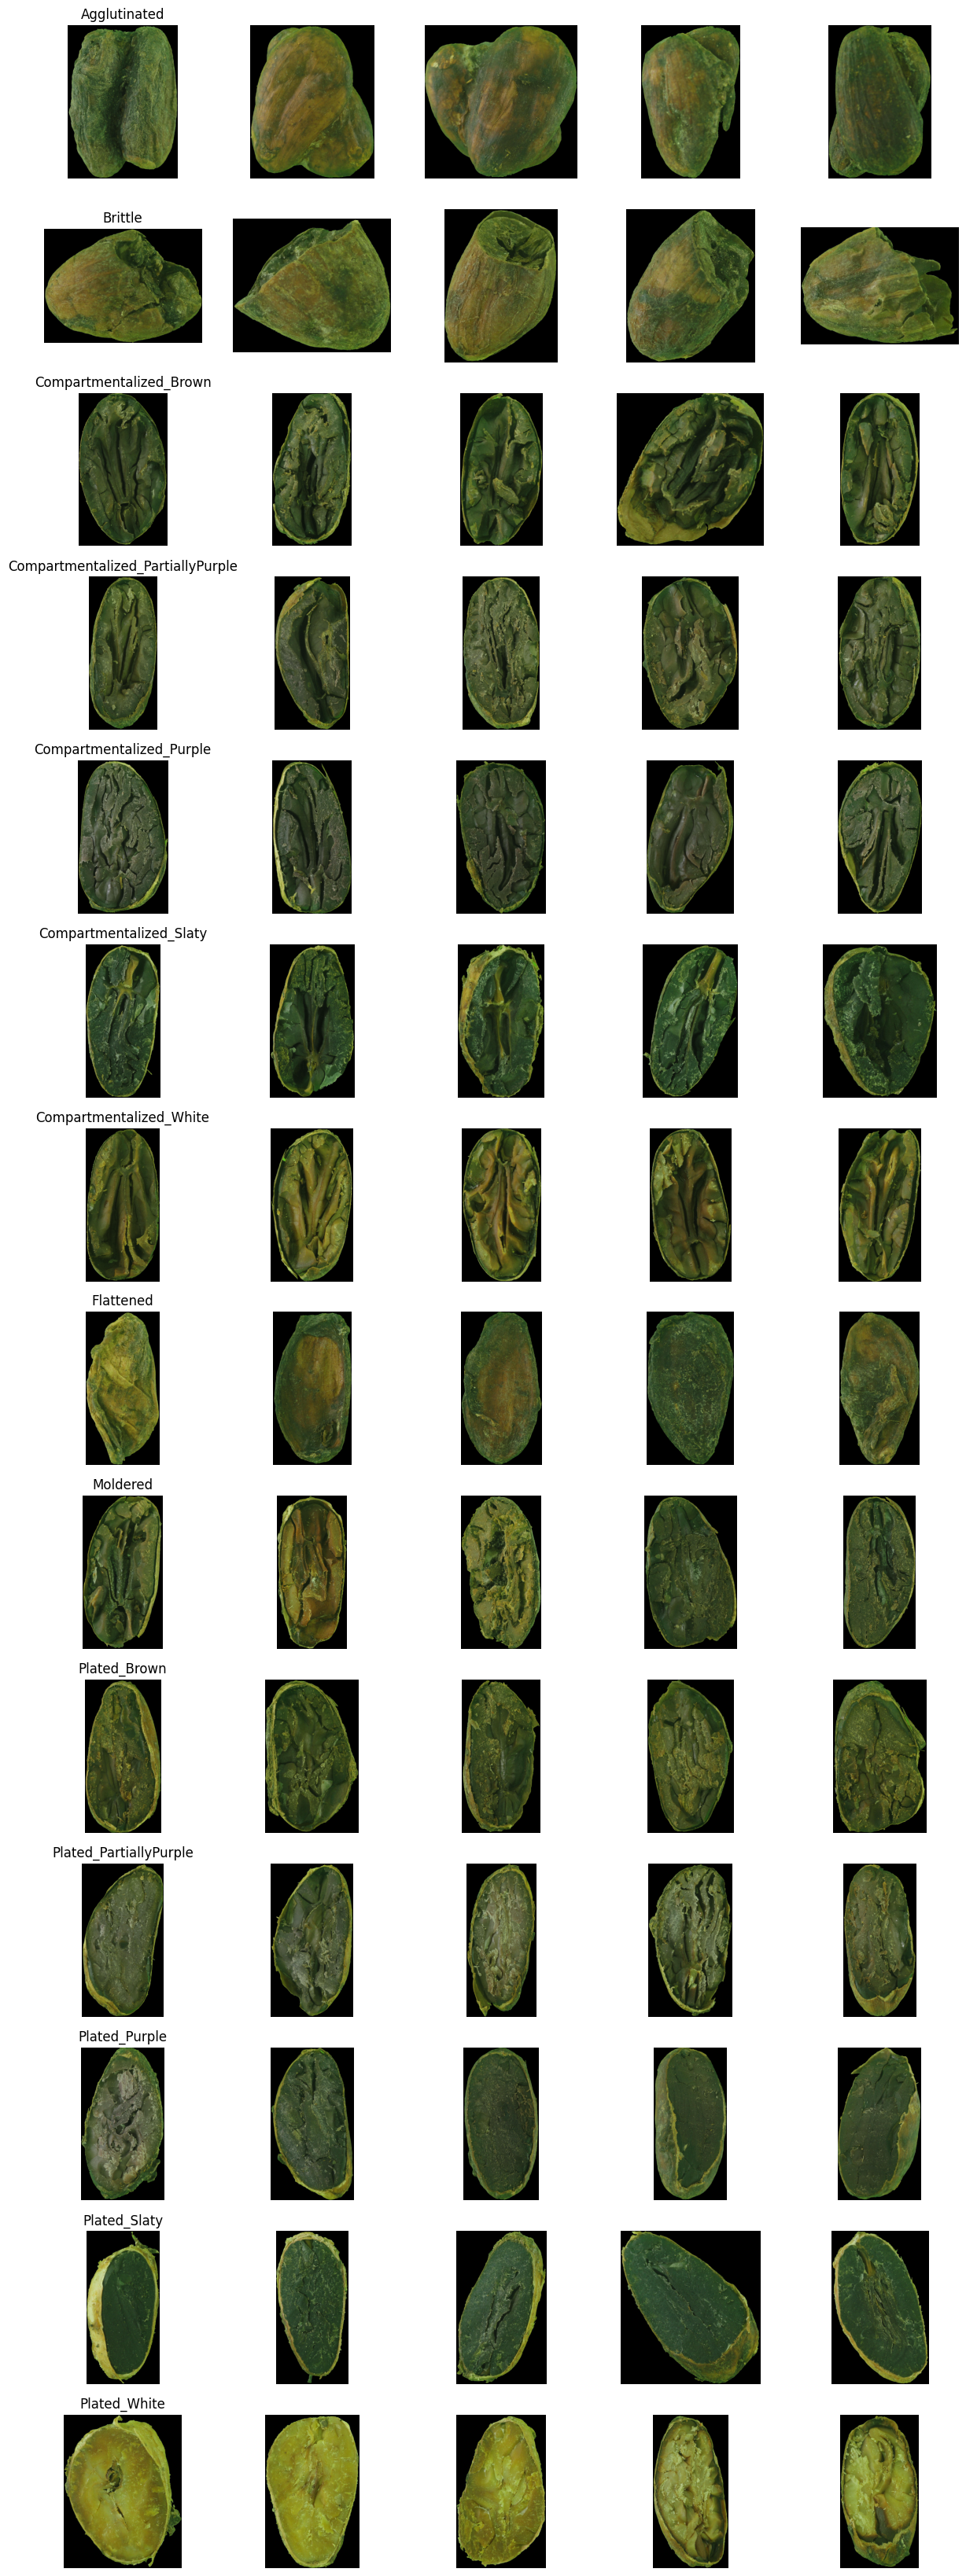

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(len(classes), 5, figsize=(15, 3*len(classes)))
for i, c in enumerate(classes):
    class_dir = os.path.join(base_dir, c)
    imgs = os.listdir(class_dir)[:5]  # pegar 5 imagens da classe
    for j, img_name in enumerate(imgs):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(c)
plt.show()


#2.PREPARAÇÃO DOS DADOS

##2.1 Carregando imagens

Padronizar imagens para entrada da CNN.

Normalizar valores de pixels (0-1 ou preprocess do Keras).

In [9]:
#Preparação de dados
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

# Arrays para features ainda não extraídas (placeholder)
X_paths = []
y_labels = []

for idx, c in enumerate(classes):
    class_dir = os.path.join(base_dir, c)

    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)

        X_paths.append(img_path)
        y_labels.append(idx)

X_paths = np.array(X_paths)
y_labels = np.array(y_labels)

##2.2 Criação da partição holdout (treino + teste)

Criar partição holdout (treino/teste) reproduzível.

In [10]:
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    X_paths, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)

As imagens da base apresentavam grande variação de resolução, com larguras entre 835 e 2393 pixels e alturas entre 1091 e 2699 pixels. Para garantir padronização e compatibilidade com as arquiteturas de deep learning utilizadas nas próximas etapas, as imagens serão redimensionadas.

Foi criada uma partição holdout, que será utilizada em todos os experimentos subsequentes — conforme exigido pelo enunciado. A divisão foi realizada de forma estratificada, preservando a proporção balanceada das classes, com 80% das imagens destinadas ao conjunto de treinamento e 20% ao conjunto de teste. O valor de random_state foi fixado em 42, garantindo reprodutibilidade em todas as execuções

#3.EXTRAÇÃO DE CARACTERÍSTICAS VISUAIS

Usar CNNs sem as camadas finais de classificação (include_top=False).

Pesos fixos (weights='imagenet').

Salvar vetores de features em disco para não recalcular.

In [11]:
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, InceptionV3, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_incep
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_eff

##3.1 Função genérica para extrair embeddings

Função genérica que também faz o resize da imagem

In [12]:
#def extract_features(model, preprocess_fn, img_paths, target_size=(224, 224)):
#    """
#    Extrai features de uma lista de imagens usando um modelo pré-treinado.
#    Args:
#        model: CNN pré-treinada do Keras (sem a camada final de classificação)
#        preprocess_fn: função de preprocessamento específica do modelo
#        img_paths: lista de caminhos das imagens
#        target_size: tupla (altura, largura) para redimensionamento da imagem
#    Returns:
#        np.array com shape (num_imagens, num_features)
#    """
#    features_list = []
#    for path in tqdm(img_paths, desc=f"Extraindo features ({model.name})"):
#        # Carregar e redimensionar imagem
#        img = image.load_img(path, target_size=target_size)
#        img_array = image.img_to_array(img)
#        img_array = np.expand_dims(img_array, axis=0)
#        img_array = preprocess_fn(img_array)

        # Extrair features sem gerar output poluído
#        features = model.predict(img_array, verbose=0)
#        features_list.append(features.flatten())

#    return np.array(features_list)

In [25]:
#codigo ajustado
def extract_features(model, preprocess_fn, img_paths, target_size):
    features_list = []

    for path in tqdm(img_paths, desc=f"Extraindo features ({model.name})"):

        # 1. Carregar imagem SEM normalizar manualmente
        img = Image.open(path).convert("RGB")
        img = img.resize(target_size)

        # 2. Converter para array SEM DIVIDIR por 255
        img_array = np.array(img)

        # 3. Expandir dims
        img_array = np.expand_dims(img_array, axis=0)

        # 4. Aplicar preprocess_input do modelo EXATAMENTE AQUI
        img_array = preprocess_fn(img_array)

        # 5. Extrair
        feat = model.predict(img_array, verbose=0)
        features_list.append(feat.flatten())

    return np.array(features_list)


##3.2 Carregar os 3 modelos SEM as camadas finais

In [13]:
import joblib

# Inicializando os modelos pré-treinados (sem camada final)
vgg_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
efficient_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


##3.3 Extrair vetores de características para os 3 modelos

In [17]:
# Extração de features
X_train_vgg = extract_features(vgg_model, preprocess_vgg, X_train_paths, target_size=(224,224))
X_test_vgg  = extract_features(vgg_model, preprocess_vgg, X_test_paths, target_size=(224,224))

X_train_incep = extract_features(inception_model, preprocess_incep, X_train_paths, target_size=(299,299))
X_test_incep  = extract_features(inception_model, preprocess_incep, X_test_paths, target_size=(299,299))

X_train_eff = extract_features(efficient_model, preprocess_eff, X_train_paths, target_size=(224,224))
X_test_eff  = extract_features(efficient_model, preprocess_eff, X_test_paths, target_size=(224,224))

# Salvar as features em disco para evitar recálculo
#features_dir = "/content/drive/MyDrive/ML2_Cacau/extracted_features"

if IN_COLAB:
    features_dir = "/content/drive/MyDrive/ML2_Cacau/extracted_features"
else:
    features_dir = "extracted_features"


os.makedirs(features_dir, exist_ok=True)

print(f"Salvando features em: {features_dir}/")
joblib.dump(X_train_vgg, os.path.join(features_dir, 'X_train_vgg.pkl'))
joblib.dump(X_test_vgg, os.path.join(features_dir, 'X_test_vgg.pkl'))
joblib.dump(X_train_incep, os.path.join(features_dir, 'X_train_incep.pkl'))
joblib.dump(X_test_incep, os.path.join(features_dir, 'X_test_incep.pkl'))
joblib.dump(X_train_eff, os.path.join(features_dir, 'X_train_eff.pkl'))
joblib.dump(X_test_eff, os.path.join(features_dir, 'X_test_eff.pkl'))
print("Features salvas com sucesso!")

Extraindo features (efficientnetb0): 100%|██████████| 280/280 [00:56<00:00,  4.97it/s]


Salvando features em: /content/drive/MyDrive/ML2_Cacau/extracted_features/
Features salvas com sucesso!


#4.ELABORAÇÃO DA BUSCA EM GRADE (GridSearch)

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


##4.1 Pipeline + GridSearch para VGG16

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Pipeline com StandardScaler, PCA e SVM
pipeline_vgg = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=256)),  # ajustado de 100 para 256
    ('svm', SVC(kernel='rbf'))
])

# Grade de parâmetros para o GridSearch
#param_grid_vgg = {
#    'svm__C': [1, 10, 50, 100, 200],
#    'svm__gamma': [0.001, 0.01, 0.1, 1]
#}

# ajustado novos parametros para o grid
param_grid_vgg = {
    'svm__C': [10, 50, 100, 200, 500, 1000, 2000, 5000],
    'svm__gamma': [0.0001, 0.0005, 0.001, 0.01, 0.1]

}

# GridSearch com validação cruzada 5-fold
grid_vgg = GridSearchCV(
    estimator=pipeline_vgg,
    param_grid=param_grid_vgg,
    cv=8,  #ajustado de 5 para 8
    n_jobs=-1,
    verbose=2
)


In [19]:
import time

# Treinar o GridSearch com as features do VGG16
print("Iniciando treinamento do GridSearch para VGG16...")
start_time_vgg = time.time()
grid_vgg.fit(X_train_vgg, y_train)
end_time_vgg = time.time()

# Ver os melhores parâmetros e a melhor acurácia CV
print("Melhores parâmetros VGG16 + SVM:", grid_vgg.best_params_)
print("Melhor acurácia CV:", grid_vgg.best_score_)
print(f"Tempo de treinamento VGG16: {end_time_vgg - start_time_vgg:.2f} segundos")

Iniciando treinamento do GridSearch para VGG16...
Fitting 8 folds for each of 40 candidates, totalling 320 fits
Melhores parâmetros VGG16 + SVM: {'svm__C': 50, 'svm__gamma': 0.001}
Melhor acurácia CV: 0.6776785714285715
Tempo de treinamento VGG16: 112.63 segundos


##4.2 Pipeline + GridSearch para InceptionV3

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Pipeline com StandardScaler, PCA e SVM
pipeline_incep = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=512)),  # ajustado de 100 para 512
    ('svm', SVC(kernel='rbf'))
])
# Grade de parâmetros para o GridSearch
#param_grid_incep = {
#    'svm__C': [1, 10, 50, 100, 200],
#    'svm__gamma': [0.001, 0.01, 0.1, 1]
#}

# ajustado novos parametros para o grid
param_grid_incep = {
    'svm__C': [10, 50, 100, 200, 500, 1000, 2000, 5000],
    'svm__gamma': [0.0001, 0.0005, 0.001, 0.01, 0.1]

}

# GridSearch com validação cruzada 5-fold
grid_incep = GridSearchCV(
    estimator=pipeline_incep,
    param_grid=param_grid_incep,
    cv=8,  #ajustado de 5 para 8
    n_jobs=-1,
    verbose=2
)

In [21]:
import time
#Treinar o GridSearch
print("Iniciando treinamento do GridSearch para InceptionV3...")
start_time_incep = time.time()
grid_incep.fit(X_train_incep, y_train)
end_time_incep = time.time()

print("Melhores parâmetros InceptionV3 + SVM:", grid_incep.best_params_)
print("Melhor acurácia CV:", grid_incep.best_score_)
print(f"Tempo de treinamento InceptionV3: {end_time_incep - start_time_incep:.2f} segundos")

Iniciando treinamento do GridSearch para InceptionV3...
Fitting 8 folds for each of 40 candidates, totalling 320 fits
Melhores parâmetros InceptionV3 + SVM: {'svm__C': 1000, 'svm__gamma': 0.0001}
Melhor acurácia CV: 0.6973214285714286
Tempo de treinamento InceptionV3: 383.95 segundos


##4.3 Pipeline + GridSearch para EfficientNet

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Pipeline com StandardScaler, PCA e SVM
pipeline_eff = Pipeline([
    ('scaler', StandardScaler()),
    #('pca', PCA(n_components=100)),  # ajustado, apenas removido
    ('svm', SVC(kernel='rbf'))
])

# Grade de parâmetros para o GridSearch
#param_grid_eff = {
#    'svm__C': [1, 10, 50, 100, 200],
#    'svm__gamma': [0.001, 0.01, 0.1, 1]
#}

# ajustado novos parametros para o grid
param_grid_eff = {
    'svm__C': [10, 50, 100, 200, 500, 1000, 2000, 5000],
    'svm__gamma': [0.0001, 0.0005, 0.001, 0.01, 0.1]

}

# GridSearch com validação cruzada 5-fold
grid_eff = GridSearchCV(
    estimator=pipeline_eff,
    param_grid=param_grid_eff,
    cv=8,  #ajustado de 5 para 8
    n_jobs=-1,
    verbose=2
)


In [23]:
import time

# Treinar usando as features extraídas da EfficientNetB0
print("Iniciando treinamento do GridSearch para EfficientNetB0...")
start_time_eff = time.time()
grid_eff.fit(X_train_eff, y_train)
end_time_eff = time.time()

# Ver melhores parâmetros e melhor acurácia CV
print("Melhores parâmetros EfficientNetB0 + SVM:", grid_eff.best_params_)
print("Melhor acurácia CV:", grid_eff.best_score_)
print(f"Tempo de treinamento EfficientNetB0: {end_time_eff - start_time_eff:.2f} segundos")

Iniciando treinamento do GridSearch para EfficientNetB0...
Fitting 8 folds for each of 40 candidates, totalling 320 fits
Melhores parâmetros EfficientNetB0 + SVM: {'svm__C': 10, 'svm__gamma': 0.0001}
Melhor acurácia CV: 0.7517857142857143
Tempo de treinamento EfficientNetB0: 330.33 segundos


##4.4 Comparação da acurácia, da validação cruzada dos 3 modelos

In [24]:
# Criar dicionário com os resultados de CV
cv_results = {
    'VGG16': grid_vgg.best_score_,
    'InceptionV3': grid_incep.best_score_,
    'EfficientNetB0': grid_eff.best_score_
}

# Mostrar resultados
for model_name, cv_score in cv_results.items():
    print(f"{model_name} - CV Acurácia: {round(cv_score*100,2)}%")

# Escolher o melhor modelo pelo CV
best_model_name = max(cv_results, key=cv_results.get)
print(f"\nMelhor modelo baseado em CV: {best_model_name}")

VGG16 - CV Acurácia: 67.77%
InceptionV3 - CV Acurácia: 69.73%
EfficientNetB0 - CV Acurácia: 75.18%

Melhor modelo baseado em CV: EfficientNetB0


#5. EXPERIMENTOS E ANÁLISE DOS RESULTADOS

In [ ]:
# -----------------------------
#  Comparar acurácia CV dos 3 modelos
# -----------------------------
cv_results = {
    'VGG16': grid_vgg.best_score_,
    'InceptionV3': grid_incep.best_score_,
    'EfficientNetB0': grid_eff.best_score_
}

print("Acurácia CV de cada modelo:")
for model_name, cv_score in cv_results.items():
    print(f"{model_name}: {round(cv_score*100,2)}%")

# Selecionar o melhor modelo pelo CV
best_model_name = max(cv_results, key=cv_results.get)
print(f"\nMelhor modelo baseado em CV: {best_model_name}")


Acurácia CV de cada modelo:
VGG16: 66.43%
InceptionV3: 66.16%
EfficientNetB0: 72.23%

Melhor modelo baseado em CV: EfficientNetB0


##5.1 Selecionar o pipeline do melhor modelo

In [ ]:
if best_model_name == 'VGG16':
    best_model = grid_vgg
    X_test_best = X_test_vgg
elif best_model_name == 'InceptionV3':
    best_model = grid_incep
    X_test_best = X_test_incep
else:
    best_model = grid_eff
    X_test_best = X_test_eff

##5.2 Avaliando no conjunto de teste apenas o melhor modelo


Acurácia final no teste (EfficientNetB0): 72.5%

Relatório completo:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.86      0.90      0.88        20
           2       0.70      0.80      0.74        20
           3       0.47      0.45      0.46        20
           4       0.76      0.80      0.78        20
           5       0.68      0.95      0.79        20
           6       0.80      0.80      0.80        20
           7       0.95      0.90      0.92        20
           8       0.67      0.50      0.57        20
           9       0.43      0.45      0.44        20
          10       0.44      0.40      0.42        20
          11       0.63      0.60      0.62        20
          12       0.95      0.90      0.92        20
          13       0.88      0.70      0.78        20

    accuracy                           0.72       280
   macro avg       0.73      0.72      0.72       280
weighted a

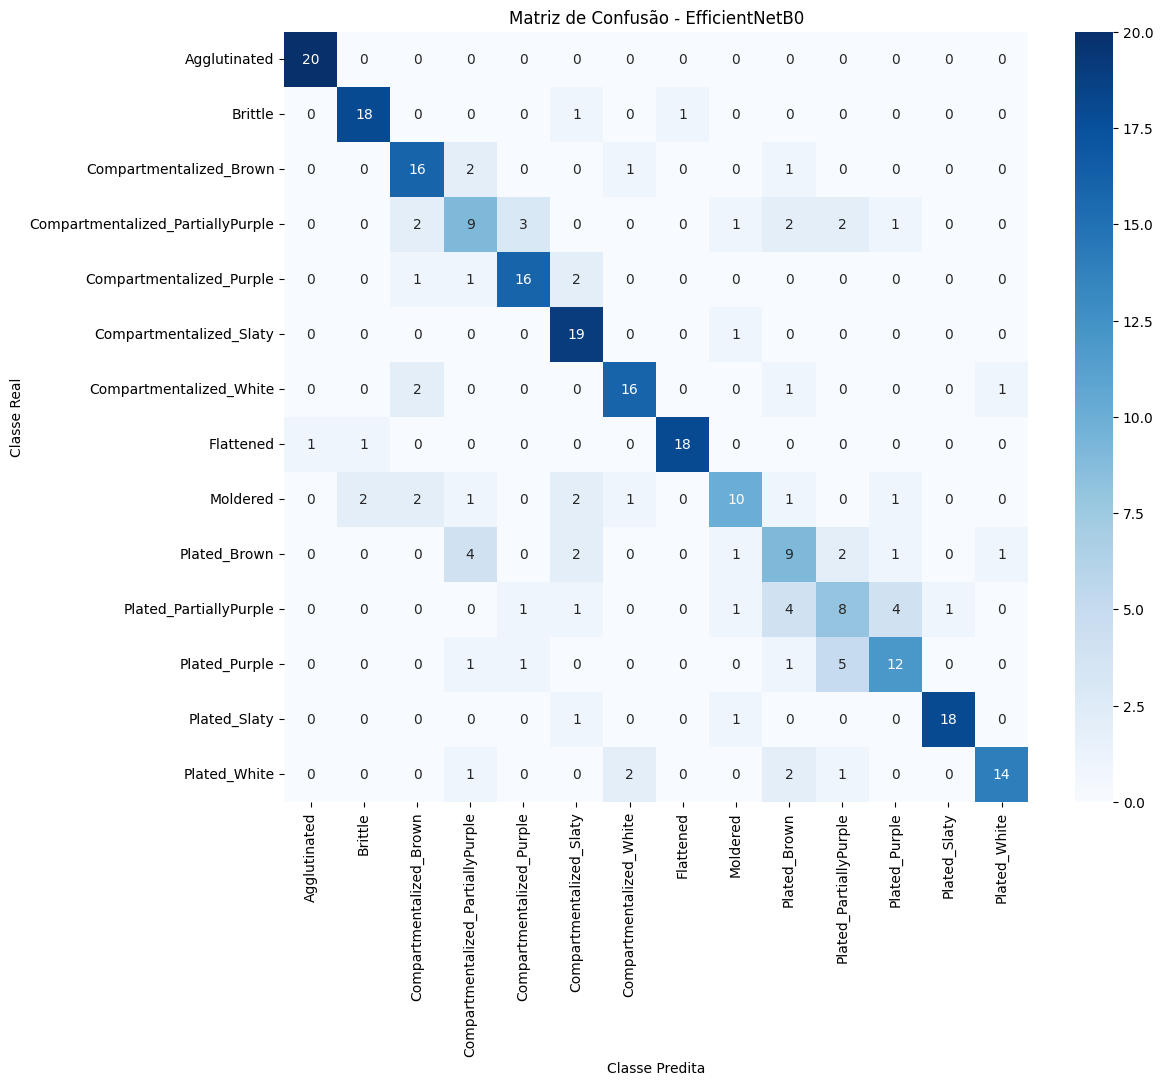

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Previsão no teste
y_pred_best = best_model.predict(X_test_best)

# 1️⃣ Acurácia
acc = round(accuracy_score(y_test, y_pred_best)*100, 2)
print(f"\nAcurácia final no teste ({best_model_name}): {acc}%\n")

# 2️⃣ Relatório completo
print("Relatório completo:")
print(classification_report(y_test, y_pred_best))

# 3️⃣ Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.show()


##5.3 Salvando o modelo final

In [ ]:
import joblib, os

os.makedirs("modelos_trained", exist_ok=True)
model_filename = f"modelos_trained/svm_best_model_{best_model_name}.pkl"
joblib.dump(best_model, model_filename)
print(f"\nModelo final ({best_model_name}) salvo com sucesso em: {model_filename}")


Modelo final (EfficientNetB0) salvo com sucesso em: modelos_trained/svm_best_model_EfficientNetB0.pkl


## 5.4 Tabela de Resultado

In [ ]:
import pandas as pd

# Dicionário com os resultados de CV
cv_results = {
    'VGG16': grid_vgg.best_score_,
    'InceptionV3': grid_incep.best_score_,
    'EfficientNetB0': grid_eff.best_score_
}

# Tempos de treinamento
training_times = {
    'VGG16': end_time_vgg - start_time_vgg,
    'InceptionV3': end_time_incep - start_time_incep,
    'EfficientNetB0': end_time_eff - start_time_eff
}

# Criar DataFrame para a tabela comparativa
df_results = pd.DataFrame({
    'Modelo': list(cv_results.keys()),
    'Acurácia CV (%)': [round(score * 100, 2) for score in cv_results.values()],
    'Tempo de Treinamento (s)': [round(time, 2) for time in training_times.values()]
})

# Ordenar pelo melhor resultado de acurácia CV
df_results = df_results.sort_values(by='Acurácia CV (%)', ascending=False).reset_index(drop=True)

display(df_results)

Modelo  Acurácia CV (%)  Tempo de Treinamento (s)
0  EfficientNetB0            72.23                     22.91
1           VGG16            66.43                     20.41
2     InceptionV3            66.16                     30.77

#Análise dos outros modelos:  Matrizes de Confusão e Relatórios de Classificação no Conjunto de Teste

Matrizes de confusão e Relatórios de classificação para cada um dos modelos (VGG16, InceptionV3 e EfficientNetB0) no conjunto de teste, realizando uma análise diagnóstica e comparativa. Isso permitirá um diagnóstico detalhado do desempenho de cada arquitetura.


--- Avaliação para VGG16 ---
Acurácia final no teste (VGG16): 63.93%

Relatório completo:
                                   precision    recall  f1-score   support

                     Agglutinated       0.89      0.85      0.87        20
                          Brittle       0.76      0.95      0.84        20
          Compartmentalized_Brown       0.54      0.65      0.59        20
Compartmentalized_PartiallyPurple       0.25      0.25      0.25        20
         Compartmentalized_Purple       0.50      0.40      0.44        20
          Compartmentalized_Slaty       0.59      0.95      0.73        20
          Compartmentalized_White       0.67      0.70      0.68        20
                        Flattened       1.00      0.80      0.89        20
                         Moldered       0.69      0.45      0.55        20
                     Plated_Brown       0.41      0.35      0.38        20
           Plated_PartiallyPurple       0.48      0.60      0.53        20
        

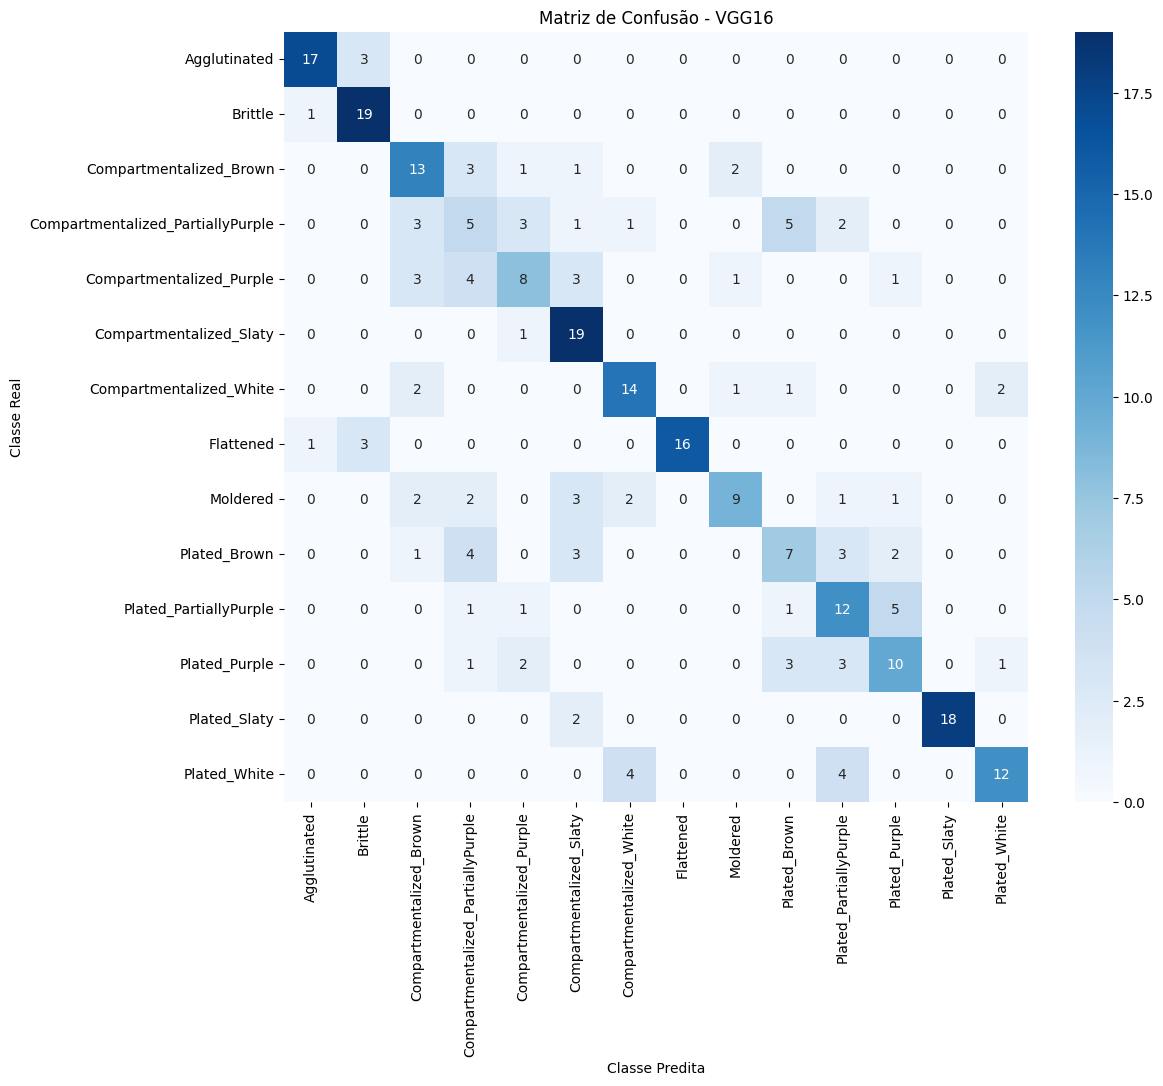


--- Avaliação para InceptionV3 ---
Acurácia final no teste (InceptionV3): 64.29%

Relatório completo:
                                   precision    recall  f1-score   support

                     Agglutinated       0.89      0.80      0.84        20
                          Brittle       0.82      0.90      0.86        20
          Compartmentalized_Brown       0.55      0.55      0.55        20
Compartmentalized_PartiallyPurple       0.23      0.25      0.24        20
         Compartmentalized_Purple       0.48      0.55      0.51        20
          Compartmentalized_Slaty       0.65      0.75      0.70        20
          Compartmentalized_White       0.75      0.75      0.75        20
                        Flattened       0.85      0.85      0.85        20
                         Moldered       0.65      0.65      0.65        20
                     Plated_Brown       0.53      0.45      0.49        20
           Plated_PartiallyPurple       0.48      0.65      0.55       

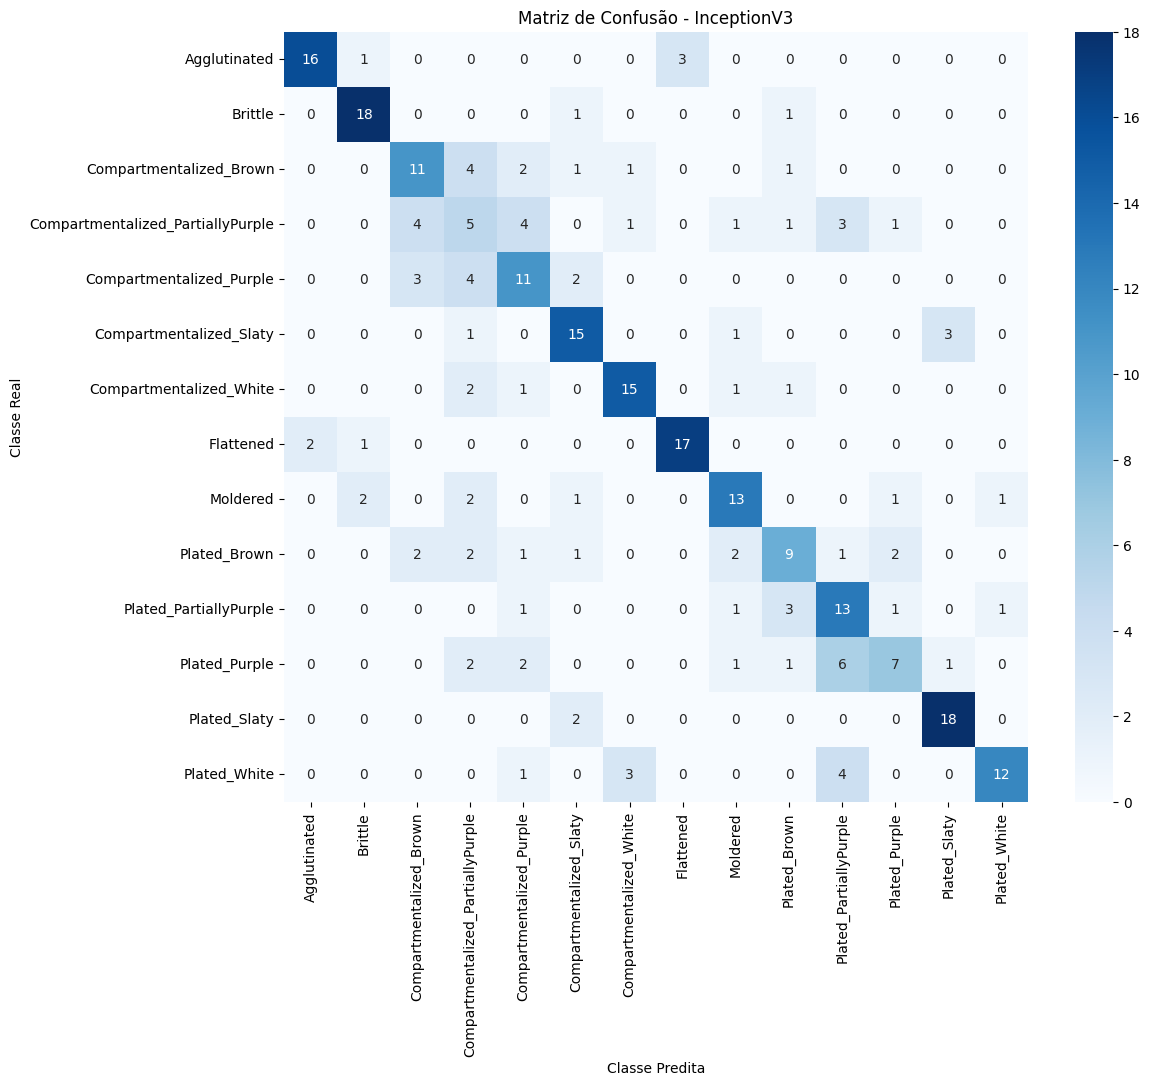


--- Avaliação para EfficientNetB0 ---
Acurácia final no teste (EfficientNetB0): 72.5%

Relatório completo:
                                   precision    recall  f1-score   support

                     Agglutinated       0.95      1.00      0.98        20
                          Brittle       0.86      0.90      0.88        20
          Compartmentalized_Brown       0.70      0.80      0.74        20
Compartmentalized_PartiallyPurple       0.47      0.45      0.46        20
         Compartmentalized_Purple       0.76      0.80      0.78        20
          Compartmentalized_Slaty       0.68      0.95      0.79        20
          Compartmentalized_White       0.80      0.80      0.80        20
                        Flattened       0.95      0.90      0.92        20
                         Moldered       0.67      0.50      0.57        20
                     Plated_Brown       0.43      0.45      0.44        20
           Plated_PartiallyPurple       0.44      0.40      0.42  

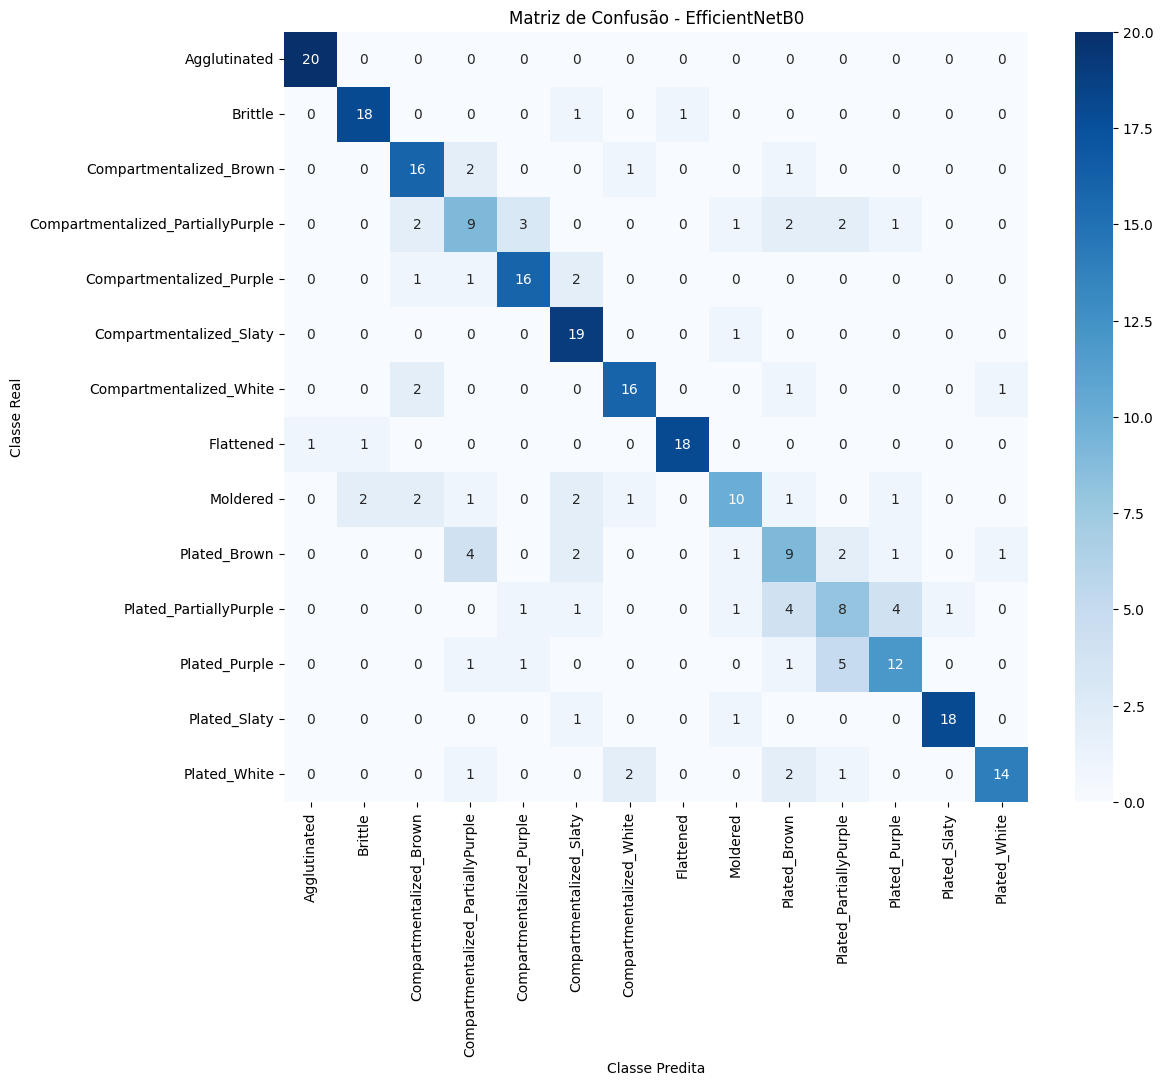

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

models = {
    'VGG16': {'grid': grid_vgg, 'X_test': X_test_vgg},
    'InceptionV3': {'grid': grid_incep, 'X_test': X_test_incep},
    'EfficientNetB0': {'grid': grid_eff, 'X_test': X_test_eff}
}

for model_name, data in models.items():
    grid_model = data['grid']
    X_test_feats = data['X_test']

    # Previsão no teste
    y_pred = grid_model.predict(X_test_feats)

    # Acurácia
    acc = round(accuracy_score(y_test, y_pred) * 100, 2)
    print(f"\n--- Avaliação para {model_name} ---")
    print(f"Acurácia final no teste ({model_name}): {acc}%\n")

    # Relatório completo
    print("Relatório completo:")
    print(classification_report(y_test, y_pred, target_names=classes))

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred);

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Classe Predita')
    plt.ylabel('Classe Real')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()
